<img src="img/saturn_logo.png" width="300" />

# Monitoring Model Learning Performance

Let's take a look at the results we get from running this exact workflow on a few different cluster sizes. You've been given the statistics results from real job runs in the repo. 

Run the next chunk, which is a bash command. This will decompress the statistics into your directory.

In [1]:
%%sh
cd ~/project/workshop-dask-pytorch/
gzip -d < ~/project/workshop-dask-pytorch/stats_cache2.tar.gz | tar xvf - > /dev/null

In [2]:
from os.path import dirname, join
import pandas as pd
import os
import typing
import json
from plotnine import *
import plotnine
import dateutil.parser
import pandas as pd

def parse_results(root):
    workers_dir = join(root, 'worker')
    workers = [int(x) for x in os.listdir(workers_dir)]
    data = []
    for w in workers:
        worker_dir = join(root, 'worker', str(w))
        worker_files = sorted(os.listdir(worker_dir))
        for idx, file in enumerate(worker_files):
            date_str = file.split('data-')[-1].split('.')[0]
            fpath = join(worker_dir, file)
            d = dict(
                count=idx,
            )
            with open(fpath) as f:
                d.update(json.load(f))
            data.append(d)
    return data

In [3]:
def process_run(dictinput):
    path, rtype, compute, size, lr, workers = dictinput
    df = pd.DataFrame(parse_results(path))
    cleaned = df[['count', 'loss', 'correct', 'sample']].groupby(['count', 'sample']).agg({'loss': ['mean', 'min', 'max'],'correct': ['mean', 'min', 'max']}).reset_index()
    cleaned['type'], cleaned['compute'], cleaned['size'], cleaned['lr'], cleaned['workers'] = [rtype,compute, size, lr, workers]
    return cleaned

def process_run_epochs(dictinput):
    path, rtype, compute, size, lr, workers = dictinput
    df = pd.DataFrame(parse_results(path))
    cleaned = df[['epoch', 'loss', 'correct', 'sample']].groupby(['epoch', 'sample']).agg({'loss': ['mean', 'min', 'max'],'correct': ['mean', 'min', 'max']}).reset_index()
    cleaned['type'], cleaned['compute'], cleaned['size'], cleaned['lr'], cleaned['workers'] = [rtype,compute, size, lr, workers]
    return cleaned

looplist = [["./stats/parallel/pt8_4wk","parallel-4worker","parallel",100,'adaptive_01', 4],
            ["./stats/parallel/pt8_10wk","parallel-10worker","parallel",100,'adaptive_01', 10],
            ["./stats/parallel/pt8_7wk","parallel-7worker","parallel",100,'adaptive_01', 7],
            ["./stats/singlenode/pt8", "single","single",100, 'adaptive_01', 1],
           ]

results = list(map(process_run, looplist))
e_results = list(map(process_run_epochs, looplist))

test4 = pd.concat(results, axis=0)
etest4 = pd.concat(e_results, axis=0)

etest4.columns = [''.join(col).strip() for col in etest4.columns.values]
test4.columns = [''.join(col).strip() for col in test4.columns.values]

plotnine.options.figure_size = (11,4)


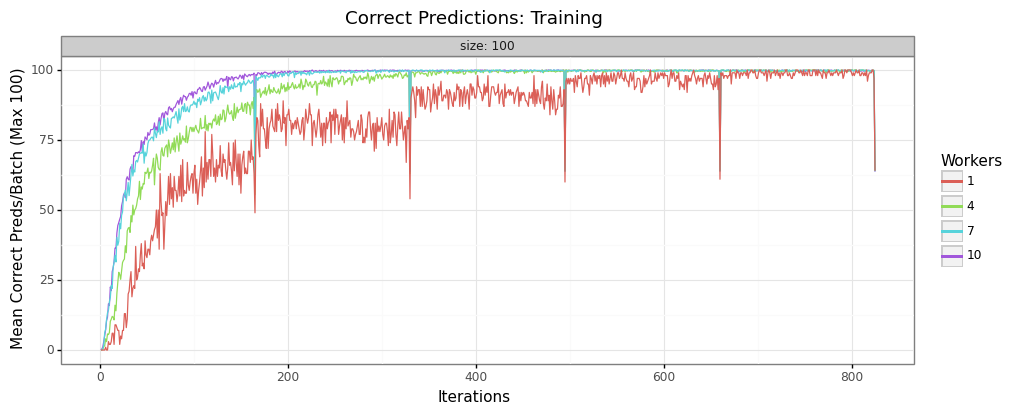

<ggplot: (8752013485381)>

In [4]:
test6 = test4.query('sample == "train"')
(ggplot(test6, aes(x='count', y='correctmean', color = "factor(workers)", group = 'type'))
        + facet_wrap(facets = ("size"), ncol=3, labeller='label_both')
        + theme_bw()
        + geom_line()
        + xlim(0, 825)
        + labs(title = 'Correct Predictions: Training', x="Iterations", y="Mean Correct Preds/Batch (Max 100)", color = "Workers"))

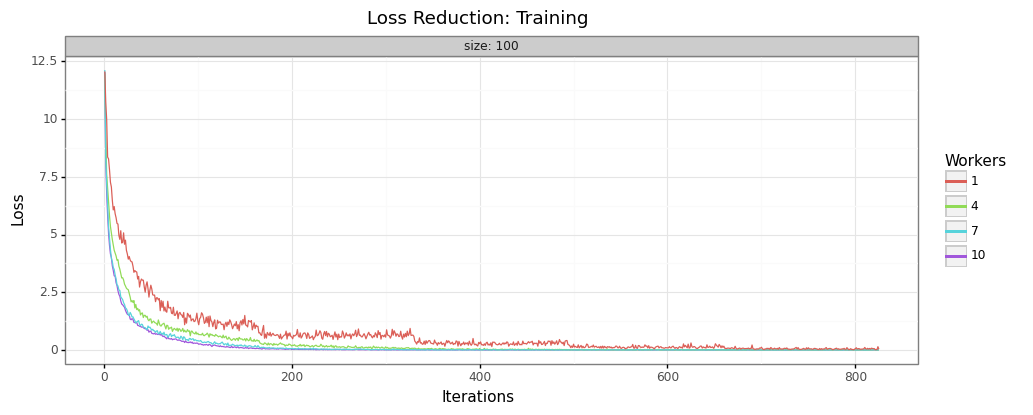

<ggplot: (8752013134377)>

In [5]:
(ggplot(test6, aes(x='count', y='lossmean', color = "factor(workers)", group = 'type'))
        + facet_wrap(facets = ("size"), ncol=3, labeller='label_both')
        + theme_bw()
        + geom_line()
        + xlim(0, 825)
        + labs(title = 'Loss Reduction: Training', x="Iterations", y="Loss", color = "Workers"))

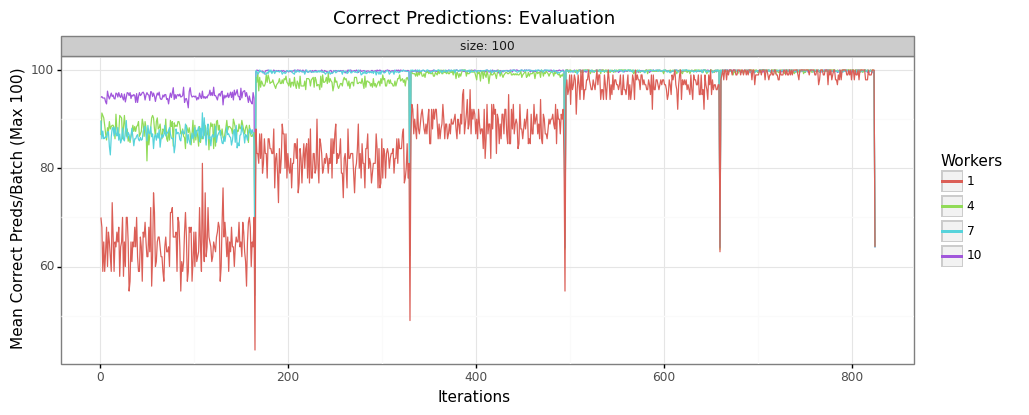

<ggplot: (8752013133505)>

In [6]:
test6 = test4.query('sample == "eval"')
(ggplot(test6, aes(x='count', y='correctmean', color = "factor(workers)", group = 'type'))
        + facet_wrap(facets = ("size"), ncol=3, labeller='label_both')
        + theme_bw()
        + geom_line()
        + xlim(0, 825)
        + labs(title = 'Correct Predictions: Evaluation', x="Iterations", y="Mean Correct Preds/Batch (Max 100)", color = "Workers"))

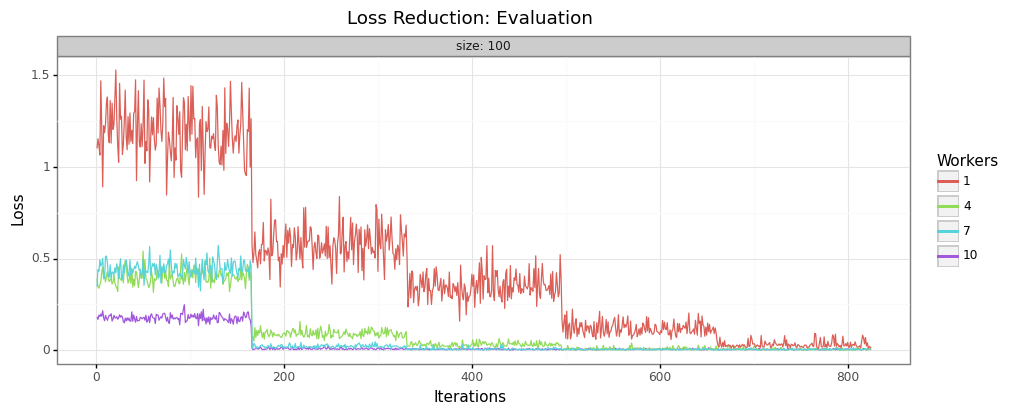

<ggplot: (8752013121881)>

In [7]:
(ggplot(test6, aes(x='count', y='lossmean', color = "factor(workers)", group = 'type'))
        + facet_wrap(facets = ("size"), ncol=3, labeller='label_both')
        + theme_bw()
        + geom_line()
        + xlim(0, 825)
        + labs(title = 'Loss Reduction: Evaluation', x="Iterations", y="Loss", color = "Workers"))

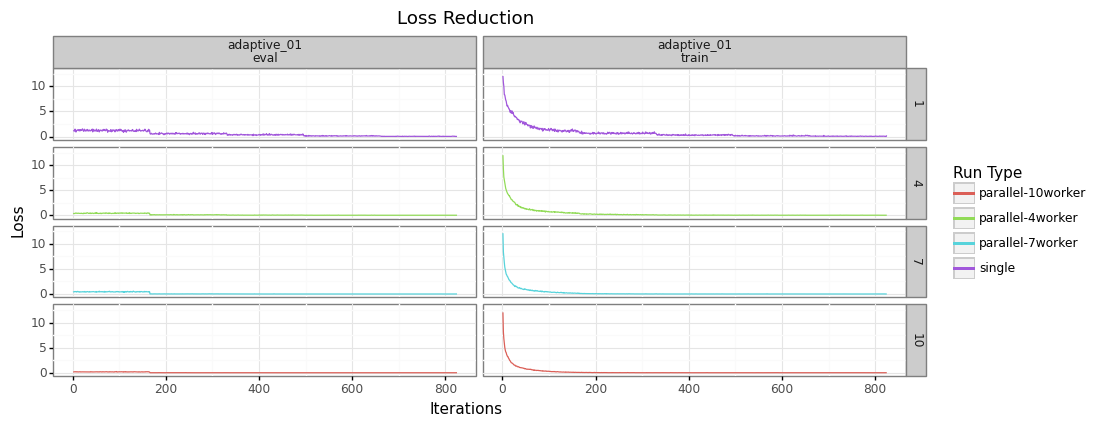

<ggplot: (8752013420313)>

In [8]:
(ggplot(test4, aes(x='count', y='lossmean', color = "factor(type)", group = 'type'))
        + facet_grid('workers~lr+sample')
        + theme_bw()
        + geom_line()
        + xlim(0, 825)
        + ylim(0, 13)
        + labs(title = 'Loss Reduction', x="Iterations", y="Loss", color = "Run Type"))

In [ ]:
(ggplot(test4, aes(x='count', y='correctmean', color = "factor(type)", group = 'type'))
        + facet_grid('workers~lr+sample')
        + theme_bw()
        + geom_line()
        + xlim(0, 825)
        + labs(title = 'Correct Predictions', x="Iterations", y="Correct (Max 100)", color = "Run Type"))

In [ ]:
test4